# Predicting LendingClub Loan Defaults with ML

The goal of this project is to develop a model for predicting whether or not a loan issued on [LendingClub](https://www.lendingclub.com/) will default.

This analysis will be done using historical loan performance data from Lending Tree (2013-2014 Loans). The original data files and a data dictionary can be found [here](https://www.lendingclub.com/info/download-data.action). This data is updated quarterly, however; I chose to stop at 2014 so that the dataset would include mostly loans which have either successfully been paid or have already defaulted.

After cleaning the dataset in a way that can be used in several types of classifier, I'll be testing the [XGBoost](https://xgboost.readthedocs.io/en/latest/) classifier (Extreme Gradient Boost). XGBoost can handle this data without this level of cleaning, however; I would like for the dataset to be portable for other models as well.

The next goal after prediction is to be able to generalize which features were most relevant to the classification. This could be used to gut check the model against domain knowledge and also to prioritize features for future modeling.

In this scenario, I'll be taking the perspective of a highly conservative investor. This means that when tuning the model, I'll err on the side of labeling as many of the true defaults as possible, potentially at the expense of generating more false positives and limiting the number of loans available for investment. In other words, I'll be prioritizing sensitivity over specificity. 

Finally, I suspect that many of the loans that my model predicts will default will be higher risk, and therefore higher interest rate loans. I will include analysis on whether or not I observe a relationship between the model's balance of sensitivity and specificity and the average rate of return on the resulting "accepted" loans.


#### Let's start with a disclaimer:

This is not intended to be taken as investment advice. While this project aims to create an ML model and compare its predictions to the historical performance of actual loans; past performance in no way guarantees future performance. You could lose money, including your principle by investing in peer-to-peer loans.

Great! Moving on...


#### Results:

The XGBoost classifier model was able to correctly classify 99% of loan defaults. The high level of sensitivity limited the field of repaid loans to 61%, however; this is preferred in the scenario. Additionally, I found that average interest rate of the remaining set of loans was not impacted by the high sensitivity rate, indicating that the model could be used to reduce risk without lowering the average rate of return.

## Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

In [2]:
pd.options.display.max_rows = 1000

## Data Import

This dataset is split into two csv files that I will combine into a single dataframe;
1. 2012-2013 Accepted Loans
2. 2014 Accepted Loans

The resulting dataset contains 150 columns of data for approx 423k loans.

In order to display the lengthy columns list, I'm increasing the max row display and transposing the head of the dataframe.

In [3]:
data_2012_13 = pd.read_csv("LoanStats3b_securev1.csv.zip", skiprows=[0], compression='zip', low_memory=False)
data_2014 = pd.read_csv("LoanStats3c_securev1.csv.zip", skiprows=[0], compression='zip', low_memory=False)
df = pd.concat([data_2012_13, data_2014], axis=0)

In [4]:
print(df.shape)
df.sample(3, random_state=1).T

(423814, 150)


,28515,196658,30159
id,34272267,12856044,8296285
member_id,NaN,NaN,NaN
loan_amnt,12000,10000,7200
funded_amnt,12000,10000,7200
funded_amnt_inv,12000,10000,7175
term,60 months,36 months,36 months
int_rate,14.31%,12.99%,12.99%
installment,281.16,336.9,242.57
grade,C,B,B
sub_grade,C4,B5,B4


## Data Cleaning Steps

#### Convert % columns to numeric

In [5]:
pct_sign_cols = ['int_rate','revol_util']
for col in pct_sign_cols:
    df[col] = df[col].str.replace("%", "").astype(float)

#### 'desc' - Drop due to messy data which is duplicated, more cleanly by 'purpose' col.

In [6]:
df = df.drop(['desc'], axis=1)

#### Deliquency Cols

Many different columns provide facts about delinquent payments (made more than 30 days after due date) in the borrower's history, including the amount currently delinquent, the number of delinquent accounts, and the number of months since the most recent delinquency on either loans or revolving credit.

Rather than keeping all of the 'months since' columns, which largely tell the same story and would need to be transformed into dummy variables over a range of months to be useful, I'll be using only the **'delinq_2yrs', 'delinq_amt', and 'pct_tl_nvr_dlq'** columns to capture deliquency information.

The **'delinq_2yrs'** col needs to have 4 missing values imputed only. The other cols are ready to use.



In [7]:
# Fill NA on 'delinq_2yrs' col. 4 missing values, filling with mode (0).
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(0)

In [8]:
# delinquent account columns dropped
delinq_drop_cols = ['acc_now_delinq', 
                    'mths_since_last_delinq', 
                    'mths_since_recent_revol_delinq',
                    'mths_since_recent_bc_dlq']

df = df.drop(delinq_drop_cols, axis=1)

#### ID columns

Dropping the **'id', 'member_id'** and **'url'** columns which are nominal and not useful in modeling.

In [9]:
df = df.drop(['id', 'member_id', 'url'], axis=1)

#### Zip Code

Zip code values are masked in the dataset to prevent identification of the individual. They show only the first 3 digits (i.e. 902xx), which are used to identify the state and the postal center that services the location. Since I already know the state and am not likely to find any value in the postal center info, I will drop zip_code entirely.

In [10]:
df = df.drop('zip_code', axis=1)

#### Purpose and Title

Comparing values in the **'purpose'** and **'title'** shows considerable overlap in the information they provide (see examples in the next cell). The title and purpose are both supplied by the borrower. The main difference is that the title is supplied from an open form while the purpose is a drop down menu of limited and uniform choices. The **'purpose'** column is much better suited for analysis as result and **'title'** will be dropped.

In [11]:
print(df[['purpose', 'title']].sample(8, random_state=1))
print("_________________________________________________")
print(df['purpose'].value_counts(dropna=False).shape)
print(df['title'].value_counts(dropna=False).shape)

df = df.drop('title', axis=1)

                   purpose                    title
28515   debt_consolidation       Debt consolidation
196658               other                    Other
30159          credit_card  Credit card relief loan
234020  debt_consolidation                     Mine
73387     home_improvement         Home improvement
145381               other                 Personal
218971  debt_consolidation       Debt consolidation
73404   debt_consolidation       Debt consolidation
_________________________________________________
(14,)
(45960,)


#### Columns Leaking Info about the Future

These columns contain information about payments that have been made on the loan or the outstanding balance. This information will not be available for future loans until they start performing. Dropping from the dataset.

In [12]:
leak_drop_cols = ["total_rec_int",
                  "total_rec_late_fee",
                  "recoveries",
                  "collection_recovery_fee",
                  "last_pymnt_d",
                  "last_pymnt_amnt",
                  "out_prncp", 
                  "out_prncp_inv", 
                  "total_pymnt", 
                  "total_pymnt_inv",
                  "total_rec_prncp",
                  "funded_amnt",
                  "funded_amnt_inv",
                  "issue_d"]

df = df.drop(leak_drop_cols, axis=1)
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=126)

#### Loan Status - Target Variable

Since the goal is predict loans which will not be fully repaid, the training data should only include loans which either were repaid or defaulted. Removing incomplete loans from the dataset. 

The **'loan_status'** column will be the target variable in the model, but cannot be used without converting to numerical values. Mapping to binary values with the positive category being "Charged Off" loans. This makes the objective of the model binary classification.

In [13]:
mapping_dict = {
    "loan_status" : {
        "Fully Paid": 0,
        "Charged Off": 1
    }
}

df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
df = df.replace(mapping_dict)

#### Employment

**'emp_title'** and **'emp_length** are both supplied by the borrower. **'emp_title'** contains over 180k unique values. Without extensive cleaning and transformation, this column is not useful and can be dropped. 

The **'emp_length'** column is helpful, however; it contains text and also groups employees with 10+ experience into the same value. Without more information, 10+ years values will have to be simplified to 10 years.

In [14]:
df = df.drop("emp_title", axis=1)

emp_mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0
    }
}

df = df.replace(emp_mapping_dict)

#### Term

The length of the payback period on the loan, either 36 or 60 months. Removing text characters and converting to numeric values.

In [15]:
df['term'] = df['term'].str.replace("months","").astype(int)
print(df['term'].value_counts(dropna=False))

36    306462
60    109106
Name: term, dtype: int64


#### Grade / SubGrade

The **'grade'** and **'sub_grade'** columns express similar information except at two different granularities. Sub_grade is more specific than grade. I only need one of the columns, so I am keeping sub_grade.

The grades are ordinal with A1 being the highest and G5 being the lowest. Remapping to numeric values.

In [16]:
subgrade_mapping_dict = {
    "sub_grade": {
        "A1": 0, "A2": 1, "A3": 2, "A4": 3, "A5":4,
        "B1": 5, "B2": 6, "B3": 7, "B4": 8, "B5":9,
        "C1": 10, "C2": 11, "C3": 12, "C4": 13, "C5":14,
        "D1": 15, "D2": 16, "D3": 17, "D4": 18, "D5": 19,
        "E1": 20, "E2": 21, "E3": 22, "E4": 23, "E5": 24,
        "F1": 25, "F2": 26, "F3": 27, "F4": 28, "F5": 29,
        "G1": 30, "G2": 31, "G3": 32, "G4": 33, "G5": 34, 
    }
}

df = df.replace(subgrade_mapping_dict)
df['sub_grade'] = df['sub_grade'].astype(int)
df = df.drop('grade', axis=1)

#### Low Variance in numerical columns

Some of the numeric columns are virtually constant. The model will not gain information from these, so they are a waste of diminsionality.

In [18]:
variance = df.var(axis=0)
print(variance[variance < .01])
low_var_columns = ['policy_code',
                   'num_tl_120dpd_2m',
                   'num_tl_30dpd',
                   'deferral_term',
                   'hardship_length']

df = df.drop(low_var_columns, axis=1)

policy_code         0.000000
num_tl_120dpd_2m    0.000818
num_tl_30dpd        0.003441
deferral_term       0.000000
hardship_length     0.000000
dtype: float64


#### Low Variance in Categorical Columns

Serveral of the 'object' datatype columns are virtually constant. Dropping all object columns which are more than 99% similar from dataset.

In [19]:
category_cols = [col for col in df.columns if df[col].dtype == 'object']
low_var_category = []
for col in category_cols:
    max_bucket = df[col].value_counts(dropna=False, normalize=True).iloc[0]
    if max_bucket > .99:
        low_var_category.append(col)
        
df = df.drop(low_var_category, axis=1)
print(low_var_category)

['pymnt_plan', 'next_pymnt_d', 'application_type', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status']


## Missing Values

Quite a few columns in the dataset are missing more than a quarter of their values. Looking at the list of columns, I'm not expecting them to have a significant impact on the outcome, so rather than remove the rows or attempt to impute such a large number of values, I'll be dropping the columns and keeping the remainder of the information from their rows.

In [20]:
mv = df.isnull().sum()
half_mv_columns = mv[mv > mv.max()/4].index
print(half_mv_columns)
df = df.drop(half_mv_columns, axis=1)

Index(['mths_since_last_record', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'revol_bal_joint', 'sec_app_fico_range_low',
       'sec_app_fico_range_high', 'sec_app_earliest_cr_line',
       'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
       'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_amount',
       'hardship_dpd', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
     

In [21]:
mv = df.isnull().sum()
print(mv)

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
sub_grade                         0
emp_length                    19612
home_ownership                    0
annual_inc                        0
verification_status               0
loan_status                       0
purpose                           0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      241
total_acc                         0
initial_list_status               0
last_credit_pull_d               34
last_fico_range_high              0
last_fico_range_low               0
collections_12_mths_ex_med  

#### Remaining MVs

A heatmap of the remaining missing values indicates that the rows with remaining missing values tend to be missing several fields. Rather than imputing multiple values for each of these records, I am removing them from the dataset.

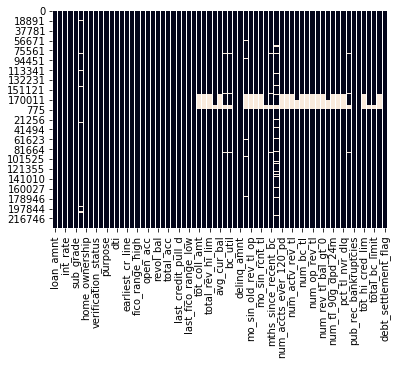

In [22]:
sns.heatmap(df.isnull(), cbar=False)

In [23]:
df = df.dropna(how='any', axis=0)
print(df.isnull().sum())

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
last_credit_pull_d            0
last_fico_range_high          0
last_fico_range_low           0
collections_12_mths_ex_med    0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open

## Check for multi-collinear columns

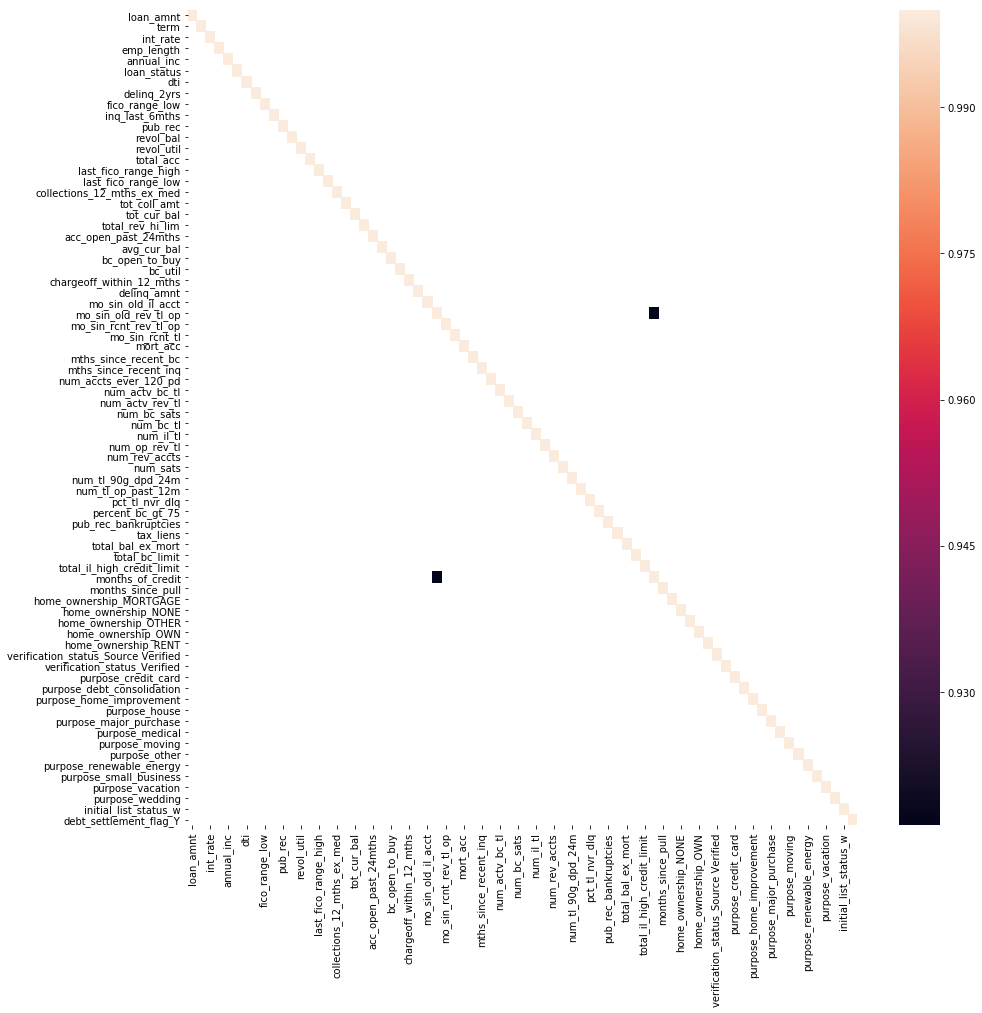

In [69]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df.corr()
corr = np.abs(corr)
ax = sns.heatmap(corr[corr > .90])

#### Loan Amount and Installment

Installment is a function of other fields that are already included in the dataset, '**loan_amnt'**, '**int_rate'**, and **'term'**. Dropping **'installment'**.

In [25]:
df = df.drop('installment', axis=1)

#### Sub_Grade and Interest Rate

The columns **'sub_grade'** and **'int_rate'** are highly correlated, which makes sense since lenders will require higher returns to make higher risk loans. Keeping the continuous variable **'int_rate'** and dropping **'sub_grade'** from the dataset.

In [26]:
df = df.drop('sub_grade', axis=1)

#### Fico Range High and Fico Range Low

The FICO range high and low move collinearly. Dropping the **'fico_range_high'** column.

In [27]:
df = df.drop('fico_range_high', axis=1)

#### Total Current Balance and Total High Credit Limit

The columns **'tot_cur_bal'** and **'tot_hi_cred_lim'** are collinear. Dropping **'tot_hi_cred_lim'**.

In [28]:
df = df.drop('tot_hi_cred_lim', axis=1)

#### Number of Satisfactory Accounts and Number of Open Accounts

The columns **'num_sats'** and **'open_acc'** are collinear. Dropping **'open_acc'**.

In [29]:
df = df.drop('open_acc', axis=1)

#### Number of Active Revolving Accounts and Number of Revolving Accounts with Zero Balance

Similarly to number of satisfactory accounts and number of open accounts, **'num_act_rev_tl'** and **'num_rev_tl_bal_gt_0'** are collinear. This trend shows that generally people with more accounts open also have more accounts which are at zero balance accross different types of credit. Dropping **'num_rev_tl_bal_gt_0'**

In [30]:
df = df.drop('num_rev_tl_bal_gt_0', axis=1)

## Datatypes

Clean up any remaining datatype issues and convert categorical object columns into binary dummy variables to use in modeling.

In [31]:
print(df.select_dtypes(['object']).columns)

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_credit_pull_d',
       'debt_settlement_flag'],
      dtype='object')


#### Employment length

**'emp_length'** could not be converted to an integer earlier due to missing values. Converting now.

In [32]:
df['emp_length'] = df['emp_length'].astype(int)

#### Earliest Credit Line

The **'earliest_cr_line'** column is a date in the format "Aug-2001" that indicates the earliest record of credit for the borrower. In order to use this, I'm converting it to 'months_of_credit' and reporting it as an integer with the column maximum (most recent date) equal to 0 months.

In [33]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
max_date = df['earliest_cr_line'].max()
df['months_of_credit'] = ((max_date - df.earliest_cr_line) / np.timedelta64(1, 'M')).astype(int)
df = df.drop('earliest_cr_line', axis=1)

#### Last Credit Pull Date

This column gets the same treatment as **'earliest_cr_line'** above. Converting to **'months_since_pull'**.

In [34]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
max_date = df['last_credit_pull_d'].max()
df['months_since_pull'] = ((max_date - df.last_credit_pull_d) / np.timedelta64(1, 'M')).astype(int)
df = df.drop('last_credit_pull_d', axis=1)

## Dummy Variables

The remaining categorical variables need to be converted to binary dummy variables in order to be useful in ML. I am using n-1 categories for each variable. The most concerning categorical variable here is **'addr_state'** as it requires 48 (49 states in the data - 1) variables. This may not be worth keeping in the data, but I'm attempting with it included first.

**EDIT**

**'addr_state'** ranked very low in feature importance in my initial trials. Removed from the dataset.

In [35]:
df = df.drop('addr_state', axis=1)

In [36]:
object_cols = df.select_dtypes(['object']).columns
dummies_df = pd.get_dummies(df[object_cols],drop_first=True)
df = pd.concat([df, dummies_df], axis=1)
df = df.drop(object_cols, axis=1)

In [37]:
print(df.head(1).T)
print(df.shape)

                                             0
loan_amnt                             10000.00
term                                     36.00
int_rate                                  9.67
emp_length                                7.00
annual_inc                           102000.00
loan_status                               0.00
dti                                      15.55
delinq_2yrs                               2.00
fico_range_low                          670.00
inq_last_6mths                            0.00
pub_rec                                   0.00
revol_bal                              9912.00
revol_util                               44.40
total_acc                                22.00
last_fico_range_high                    679.00
last_fico_range_low                     675.00
collections_12_mths_ex_med                0.00
tot_coll_amt                              0.00
tot_cur_bal                           39143.00
total_rev_hi_lim                      22300.00
acc_open_past

# Predict

Now that my dataset is ready for use in ML, it's time to make some predictions on the target column, **'loan_status'**. Since I'm trying to predict whether a loan will default (**'loan_status'** = 1) or be repayed (**'loan_status'** = 0), this is a classification problem suited for logistic regression.

#### Error Measuring

Measuring performance of prediction for this problem entail comparing four metrics (confusion matrix). The 'positive' case in our scenario is a loan default:
1. **True Positive**: Predicted a default, loan defaulted. The model has caught an unsuccessful investment before it was made.
2. **False Positive**: Predicted a default, loan repaid. The model has blocked what would have been a good investment. For investment decisions, the impact of this error is that it cuts the field of potential investments and in all likely hood, does so by preventing the riskiest/highest return (**'int_rate'**) loans from the portfolio, reducing its overall return.
3. **True Negative**: Predicted repayment, loan was repaid. The model has successfully identified a good investment opportunity.
4. **False Negative**: Predicted repayment, loan defaulted. The model has failed to prevent the investor from making a loan that would not be repaid. This metric should be as close to zero as possible as it takes many successful loans to offset a single defaulted loan. Reducing this number will likely involve a tradeoff to increasing FPs.

## XGBoost


#### Define features and target, DMatrix

In [38]:
features = [col for col in df.columns if col != 'loan_status']
X = np.array(df[features])
y = np.array(df.loan_status)
data_dmatrix = xgb.DMatrix(data=X,label=y)

#### Define Weighting of Positive Cases

In [39]:
pos_weight = (df[df['loan_status'] == 1].shape[0] / df[df['loan_status'] == 0].shape[0])
print(pos_weight)

print(df['loan_status'].value_counts(dropna=False))

0.2096157479124948
0    264670
1     55479
Name: loan_status, dtype: int64


#### Cross-validation to find optimal n-rounds

Cross validating with the parameters below shows a model which stops improving around the 170th boosting round and does not show significant overfitting. Test and train AUC values both around .963.

In [40]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.6, 'eta': .2,
                'max_depth': 7, 'alpha': 10, 'sub_sample': .8, 'scale_pos_weight': pos_weight, 'gamma': 5}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=4,
                    num_boost_round=300, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=1)


In [41]:
print(cv_results.tail(100))

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
81         0.963918       0.000096       0.963075      0.000577
82         0.963918       0.000096       0.963075      0.000577
83         0.963918       0.000096       0.963075      0.000577
84         0.963925       0.000104       0.963077      0.000575
85         0.963928       0.000106       0.963079      0.000576
86         0.963934       0.000111       0.963085      0.000578
87         0.963934       0.000111       0.963085      0.000578
88         0.963934       0.000111       0.963085      0.000578
89         0.963934       0.000111       0.963085      0.000578
90         0.963934       0.000111       0.963085      0.000578
91         0.963938       0.000109       0.963089      0.000584
92         0.963945       0.000116       0.963098      0.000587
93         0.963945       0.000116       0.963098      0.000587
94         0.963945       0.000116       0.963098      0.000587
95         0.963945       0.000116      

#### Train/Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Train Model

In the training stage, I'm again seeing roughly .963 AUC on the test set and the training performs only slightly better at .964, indicating that the model is generalizing well on unseen data.

In [43]:
dtrain = xgb.DMatrix(data=np.array(X_train),label=np.array(y_train), feature_names=features)
dtest = xgb.DMatrix(data=np.array(X_test),label=np.array(y_test), feature_names=features)

params = {"objective":"binary:logistic",'colsample_bytree': 0.6, 
          'eta': .2, 'max_depth': 7, 'alpha': 10, 'sub_sample': .8, 
          'scale_pos_weight': pos_weight, 'gamma': 5, 'eval_metric': 'auc'}

watchlist = [(dtest, 'eval'), (dtrain, 'train')]

bst = xgb.train(params=params, 
          dtrain=dtrain, 
          num_boost_round=300, 
          evals=watchlist, 
          early_stopping_rounds=20, 
          )

[0]	eval-auc:0.886572	train-auc:0.884623
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.928372	train-auc:0.928153
[2]	eval-auc:0.945575	train-auc:0.945673
[3]	eval-auc:0.947155	train-auc:0.947329
[4]	eval-auc:0.949904	train-auc:0.950122
[5]	eval-auc:0.949784	train-auc:0.949938
[6]	eval-auc:0.950524	train-auc:0.950746
[7]	eval-auc:0.951887	train-auc:0.951941
[8]	eval-auc:0.951455	train-auc:0.951669
[9]	eval-auc:0.95318	train-auc:0.953636
[10]	eval-auc:0.954001	train-auc:0.954449
[11]	eval-auc:0.955182	train-auc:0.955576
[12]	eval-auc:0.956059	train-auc:0.956561
[13]	eval-auc:0.956371	train-auc:0.956929
[14]	eval-auc:0.956931	train-auc:0.957448
[15]	eval-auc:0.957121	train-auc:0.95768
[16]	eval-auc:0.957434	train-auc:0.958183
[17]	eval-auc:0.957816	train-auc:0.958629
[18]	eval-auc:0.958341	train-auc:0.959258
[19]	eval-auc:0.958554	train-auc:0.959429
[20]	eval-auc:0.959734	train-

#### Predictions

Note that the predictions returned are in probability rather than class. I will need to determine a threshold for class assignment before plotting.

In [44]:
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
y_true = y_test

#### Confusion Matrix Function

The first cell below defines a function for visualizing the confusion matrix from our predictions. This was adapted from sklearn docs. I will use these to visualize results of gridsearching thresholds for logistic classification.

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Function to Calculate Avg. Interest Rate

This will be used to calculate the average interest rate of the loans which are accepted by the model.

In [48]:
def int_rate_mean(threshold):
    _int_df = pd.DataFrame()
    _features_df = pd.DataFrame(X_train, columns=features)
    _int_df['y_pred'] = y_pred
    _int_df = pd.concat([_int_df, _features_df], axis=1)
    _loans_taken = _int_df.loc[_int_df['y_pred'] <= threshold, 'int_rate']
    _avg_rate = _loans_taken.mean()
    print("{} loans invested, {:.4}% average interest rate.".format(_loans_taken.shape[0], _avg_rate))


## GridSearch Logistic Threshold

Reminder that in this given domain, I would like my predictions to effectively screen out as many defaults as possible without regard to the impact on overall accuracy, I will be testing some very low probability thresholds for the 'loan_status' == 1 default label.

#### Results

The initial 50% probability threshold was predicting 99% of repaid loans correctly, but letting 46% of the defaults pass through.

Using a very low threshold, 0.0038, yielded predictions that correctly labeled 99% of loan defaults. The trade-off is that it also blocked 39% of the good loans.

Threshold: 0.5
57697 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.99 0.01]
 [0.46 0.54]]
Confusion matrix, without normalization
[[52608   390]
 [ 5089  5943]]


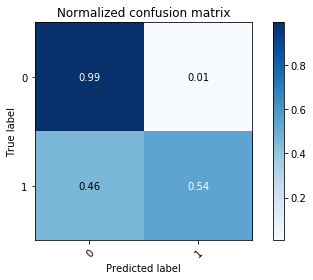

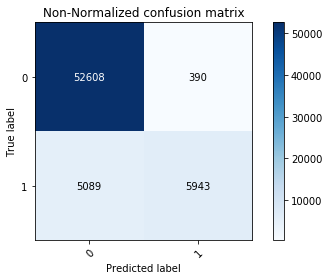

Threshold: 0.05
49636 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.91 0.09]
 [0.12 0.88]]
Confusion matrix, without normalization
[[48280  4718]
 [ 1356  9676]]


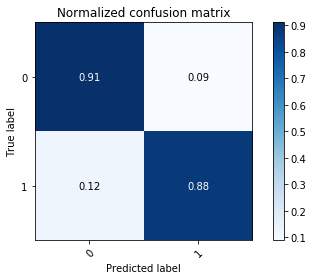

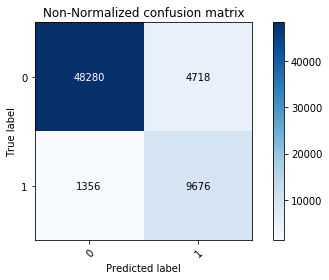

Threshold: 0.025
45039 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.84 0.16]
 [0.06 0.94]]
Confusion matrix, without normalization
[[44339  8659]
 [  700 10332]]


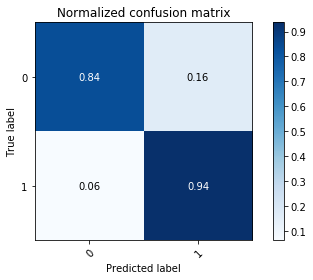

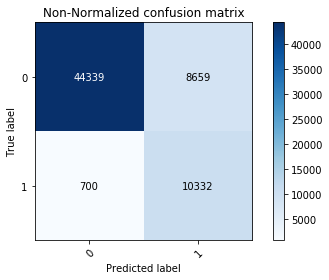

Threshold: 0.0125
40277 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.75 0.25]
 [0.03 0.97]]
Confusion matrix, without normalization
[[39904 13094]
 [  373 10659]]


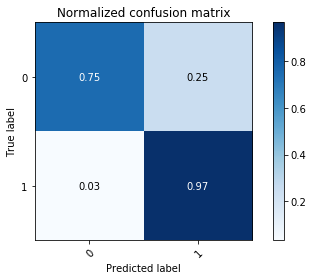

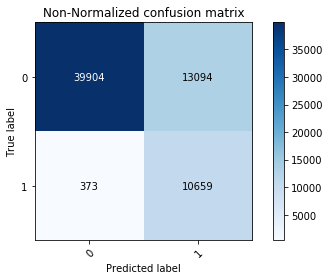

Threshold: 0.0075
37176 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.7  0.3 ]
 [0.02 0.98]]
Confusion matrix, without normalization
[[36932 16066]
 [  244 10788]]


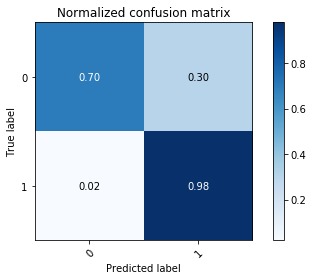

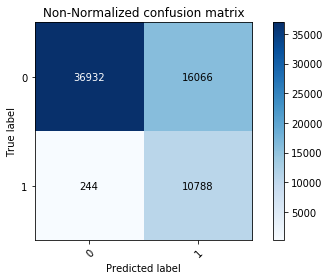

Threshold: 0.0038
32629 loans invested, 14.1% average interest rate.
Normalized confusion matrix
[[0.61 0.39]
 [0.01 0.99]]
Confusion matrix, without normalization
[[32501 20497]
 [  128 10904]]


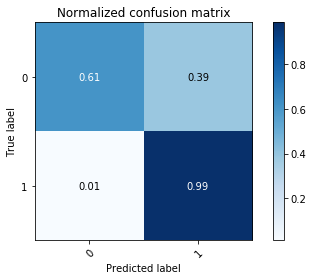

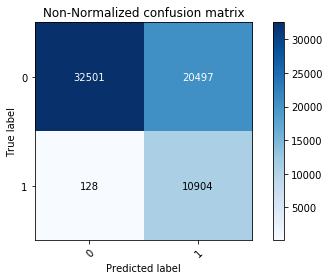

Threshold: 0.0019
27481 loans invested, 14.11% average interest rate.
Normalized confusion matrix
[[0.52 0.48]
 [0.01 0.99]]
Confusion matrix, without normalization
[[27405 25593]
 [   76 10956]]


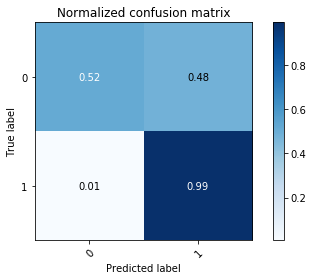

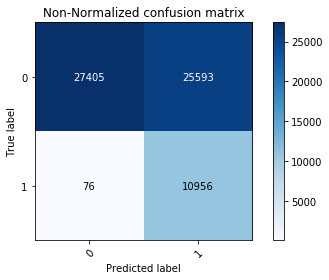

In [49]:
thresholds = [.5, .05, .025, .0125, .0075, .0038, .0019]

for th in thresholds:
    print("Threshold: {}".format(th))
    int_rate_mean(th)
    np.set_printoptions(precision=2)
    y_pred_label = np.where(y_pred > th, 1, 0)

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred=y_pred_label, classes=df.loan_status, normalize=True,
                          title='Normalized confusion matrix')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred=y_pred_label, classes=df.loan_status, normalize=False,
                          title='Non-Normalized confusion matrix')

    plt.show()

#### Impact of sensitivity on interest rates

Surprisingly, increasing the sensitivity of the model to filter out more defaults did not lead to a reduction in the average interest rate of the remaining basket of loans. This is a valuable insight because it shows how ML could reduce investment risk without reducing the expected return rate. If an investor were to rely instead on a traditional metric like FICO, they would see more of a trade off to lower interest rates as scores increase (-.31 correlation coef).

In [91]:
test_df = pd.DataFrame(X_test, columns=features)
test_corrs = test_df.corr()
print("Int Rate / Fico Corr Coef: {}".format(test_corrs['int_rate']['last_fico_range_high']))

thresholds = [.5, .05, .025, .0125, .0075, .0038, .0019]
for th in thresholds:
    int_rate_mean(th)
    
    

Int Rate / Fico Corr Coef: -0.318759176245523
57697 loans invested, 14.1% average interest rate.
49636 loans invested, 14.1% average interest rate.
45039 loans invested, 14.1% average interest rate.
40277 loans invested, 14.1% average interest rate.
37176 loans invested, 14.1% average interest rate.
32629 loans invested, 14.1% average interest rate.
27481 loans invested, 14.11% average interest rate.


#### Feature Importance

The most important features in terms of information gain are intuitive; 
1. **'last_fico_range_high'** & **'last_fico_range_low'** - It should not come as a surprise that these features are important in the model given that FICO is an independent measure of the borrower's creditworthiness which is based in part on their past borrowing activity. Borrowers with higher FICO scores are less likely to default.
2. **'debt_settlement_flag_Y'** - This is another feature that is linked to the borrower's past credit activity. A debt_settlement_flag_Y indicator has a positive correlation with loan defaults.
3. **'months_since_pull'** - This feature indicates how up-to-date the borrower's credit information is. The longer it has been since a pull, the less likely it is to be accurate. This feature has a positive correlation with defaults.
4. **'term'** - Loans with longer terms are more likely to default.

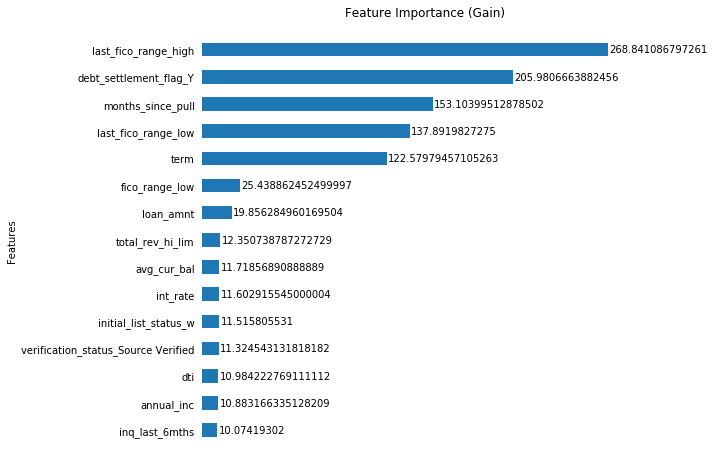

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(bst, 
                    max_num_features=15, 
                    height=0.5, 
                    ax=ax, 
                    xlabel="", 
                    title="Feature Importance (Gain)",
                    importance_type='gain')
ax.grid(False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_xticklabels([])
plt.show()